In [11]:
#!pip install pyBigWig
import pandas as pd
import pyBigWig 
import matplotlib.pyplot as plt
import seaborn as sns

#ez=pyBigWig.open('data/chip_ezh2/ENCFF105JFX.bigWig') # EZH2 ESC fold-change binding HG38
def bl(t,b): #remove blacklist regions
    bl=pd.read_table('data/'+b,header=None)
    bl['r']=bl.apply(lambda x: set(range(x[1],x[2])),axis=1)
    bg=bl.groupby(0)['r'].apply(list)
    bg=bg.apply(lambda x:set.union(*x))   
    t['r']=t.apply(lambda x: set(range(x[1],x[2])),axis=1)
    t['bl']=t.apply(lambda x: len(x['r'].intersection(bg[x['ch']])),axis=1)
    t=t[t['bl']==0].drop('r',axis=1)
    return t
#ploting function 
def pwg(cells,folder,x,chrs=22,color=[],w=.9,ylabel='DNAm',figure='f'): 
    bs=[]
    for cell in cells:
        print(cell,end=',')
        bw=pyBigWig.open('data/'+folder+cell+'.bw')
        bsc=[]
        for ch in range(1,chrs+1):
            bsc.append(bw.stats('chr'+str(ch),0,-1)[0])
        bs.append(bsc)
    bs=pd.DataFrame(bs)
    pl=pd.DataFrame(bs.mean(1))
    pl[x]=cells
    fig, ax = plt.subplots(figsize=(w,2));
    ax=sns.barplot(data=pl,x=x,y=0);
    ax.set(ylabel=ylabel,title='All CpGs');
    plt.xticks(rotation=90,fontsize=8); 
    fig.savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return bs
def pprc(tp,color=[],title='DNAm at LMRs',r=10**5,w=3,ylabel='DNAm',figure='f'):
    ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2))    
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('LMRs ranked by PRC2 binding', fontsize=10)
    ax.set(ylabel=ylabel,title=title);
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    plt.show()
def pprch(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(10**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    labels=tp.columns
    handles, labels = ax.get_legend_handles_labels()    
    ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg    
def pprchz(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(9**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    if len(labels)==0: 
        labels=tp.columns
        handles, labels = ax.get_legend_handles_labels()    
        ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    else:
        handles, l = ax.get_legend_handles_labels()    
        ax.legend([handles[-1],handles[0]], [labels[-1],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg


In [12]:
%%time


folder='t_cell/';cell='t'

ez=pyBigWig.open('data/'+folder+'EZH2_CD4_pooled_ENCinp_fe.bw') # EZH2 CD4 fold-change binding HG38

# s1. get ezh2 binding within HMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=['0','18','25','82','86','100']
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/t_cell/t_cell_lmrs_CD4pooled_prc2_ENCinp_FE_meth.csv') 

57874
0,.......................................................
18,.......................................................
25,.......................................................
82,.......................................................
86,.......................................................
100,.......................................................
CPU times: user 1min 22s, sys: 19.9 s, total: 1min 42s
Wall time: 1min 48s


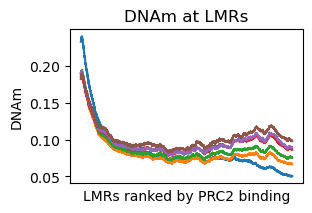

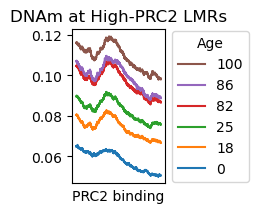

In [13]:

dft= pd.read_csv('data/t_cell/t_cell_lmrs_CD4pooled_prc2_ENCinp_FE_meth.csv',index_col=0) 

cells=['0','18','25','82','86','100']
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
#pl=pwg(cells,folder,'passage',figure='t_cell_lmrs_totalMeth')
dg=pprc(df,figure='f6a_CD4_LMRs')

dg=pprchz(df,6,5,legend_title='Age',figure='Fig6a_CD4_LMRs_zoom2')

       0     18     25     82     86    100
0  0.000  0.039  0.045  0.087  0.166  0.000
1  0.024  0.233  0.000  0.077  0.175  0.000
2  0.104  0.000  0.000  0.000  0.140  0.190
3  0.000  0.000  0.000  0.000  0.250  0.000
4  0.000  0.014  0.000  0.011  0.000  0.011
5  0.144  0.386  0.451  0.425  0.398  0.076
6  0.000  0.000  0.000  0.000  0.083  0.000
7  0.000  0.000  0.000  0.095  0.237  0.000
8  0.000  0.107  0.062  0.011  0.494  0.036
9  0.000  0.000  0.000  0.000  0.000  0.000
            0
0    0.063566
18   0.080754
25   0.090576
82   0.103830
86   0.105749
100  0.114460


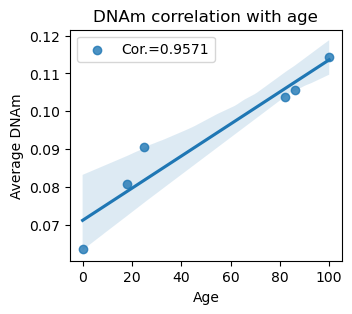

In [14]:
#mean corr plots

p= pd.read_csv('data/t_cell/t_cell_lmrs_CD4pooled_prc2_ENCinp_FE_meth.csv', usecols=['0','18','25','82','86','100']) 

cells=['0','18','25','82','86','100']
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Age']=[0,18,25,82,86,100]
figure='Fig6a_Tcell_corr_top1000CD4'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)))
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')

In [15]:
%%time


folder='Neo/';cell='NEO2_allPs'

ez=pyBigWig.open('data/'+folder+'NEO_P2_Merged_fe.bw') # EZH2 NEO passage 2 fold-change binding HG38

# s1. get ezh2 binding within HMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/Neo/NEOP2s_methBWs_NEOMergeP2_FE.csv') 

80176
NEO2_P2_meth,..............................................................................
NEO2_P5_meth,..............................................................................
NEO2_P8_meth,..............................................................................
CPU times: user 1min 54s, sys: 29.8 s, total: 2min 24s
Wall time: 2min 30s


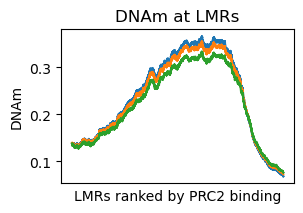

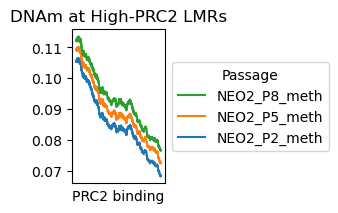

In [16]:

dft= pd.read_csv('data/Neo/NEOP2s_methBWs_NEOMergeP2_FE.csv',index_col=0) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
#pl=pwg(cells,folder,'passage',figure='t_cell_lmrs_totalMeth')
dg=pprc(df,figure='Fig6a_Neos')

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6a_Neos_zoom2')

   NEO2_P2_meth  NEO2_P5_meth  NEO2_P8_meth
0         0.185         0.183         0.209
1         0.193         0.180         0.217
2         0.025         0.031         0.022
3         0.062         0.042         0.050
4         0.070         0.074         0.073
5         0.389         0.412         0.400
6         0.060         0.064         0.071
7         0.010         0.009         0.005
8         0.346         0.367         0.405
9         0.009         0.014         0.008
                     0
NEO2_P2_meth  0.080583
NEO2_P5_meth  0.084864
NEO2_P8_meth  0.089165


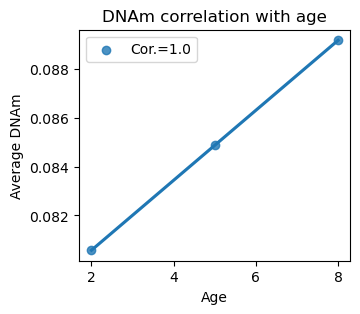

In [18]:
#mean corr plots

p= pd.read_csv('data/Neo/NEOP2s_methBWs_NEOMergeP2_FE.csv', usecols=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Passage']=[2,5,8]
figure='Fig6a_NEO_corr_top1000'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)),ci=None)
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')

In [19]:
%%time


folder='Old/';cell='OLD3_AllPs'

ez=pyBigWig.open('data/'+folder+'OLD_P2_Merged_fe.bw') # EZH2 OLD passage 2 fold-change binding HG38

# s1. get ezh2 binding within HMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/Old/OLDP2s_methBWs_OLDMergeP2_FE.csv') 

80573
OLD3_P2_meth,..............................................................................
OLD3_P5_meth,..............................................................................
OLD3_P8_meth,..............................................................................
CPU times: user 1min 17s, sys: 16.3 s, total: 1min 33s
Wall time: 1min 37s


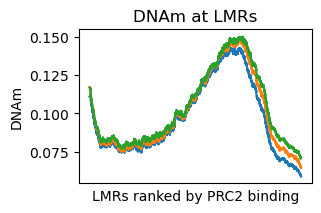

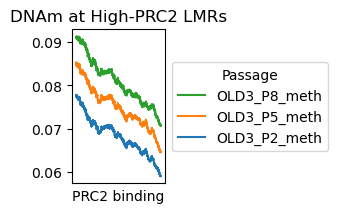

In [20]:

dft= pd.read_csv('data/Old/OLDP2s_methBWs_OLDMergeP2_FE.csv',index_col=0) 

cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
#pl=pwg(cells,folder,'passage',figure='t_cell_lmrs_totalMeth')
dg=pprc(df,figure='Fig6a_Olds')

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6a_Olds_zoom2')

   OLD3_P2_meth  OLD3_P5_meth  OLD3_P8_meth
0         0.265         0.305         0.186
1         0.013         0.132         0.565
2         0.219         0.129         0.066
3         0.132         0.140         0.144
4         0.026         0.091         0.134
5         0.000         0.034         0.034
6         0.000         0.053         0.039
7         0.061         0.079         0.070
8         0.000         0.000         0.020
9         0.147         0.063         0.101
                     0
OLD3_P2_meth  0.071200
OLD3_P5_meth  0.079420
OLD3_P8_meth  0.085888


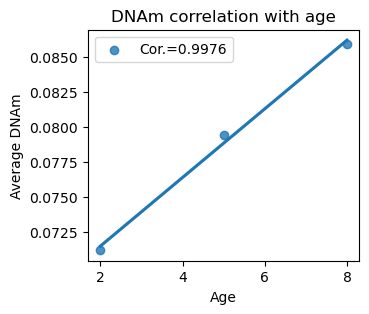

In [21]:
#mean corr plots

p= pd.read_csv('data/Old/OLDP2s_methBWs_OLDMergeP2_FE.csv', usecols=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]) 

cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Passage']=[2,5,8]
figure='Fig6a_OLD_corr_top1000'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)),ci=None)
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')

In [22]:
%%time

#NEO PRC2 Index hESC binding order

folder='Neo/';cell='NEO2_allPs'

ez=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_ezh2/ENCFF105JFX.bigWig') # EZH2 esc fold 
su=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_emb_suz/ENCFF224RZW.bigWig') # suz12 esc fold 

t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
#t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)

t['ez']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
t['su']=t.apply(lambda x:su.stats(x[0],x[1],x[2])[0],axis=1)
t['pr']=t[['ez','su']].mean(1)

print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/Neo/NEOP2s_methBWs_hESCord_FE.csv') 

80176
NEO2_P2_meth,..............................................................................
NEO2_P5_meth,..............................................................................
NEO2_P8_meth,..............................................................................
CPU times: user 2min, sys: 25 s, total: 2min 25s
Wall time: 2min 27s


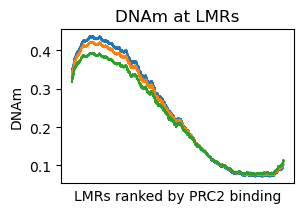

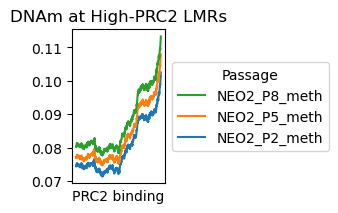

In [23]:

dft= pd.read_csv('data/Neo/NEOP2s_methBWs_hESCord_FE.csv',index_col=0) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
#pl=pwg(cells,folder,'passage',figure='t_cell_lmrs_totalMeth')
dg=pprc(df,figure='Fig6b_Neos')

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6b_Neos_zoom2')

In [24]:
%%time

#OLD PRC2 Index hESC binding order

folder='Old/';cell='OLD3_allPs'

ez=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_ezh2/ENCFF105JFX.bigWig') # EZH2 esc fold 
su=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_emb_suz/ENCFF224RZW.bigWig') # suz12 esc fold 

#get the t cell hmr and put in folder that mahdi used...either Ive got it or its somewhere in the shared folder.
# s1. get ezh2 binding within HMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
#t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)

t['ez']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
t['su']=t.apply(lambda x:su.stats(x[0],x[1],x[2])[0],axis=1)
t['pr']=t[['ez','su']].mean(1)

print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/Old/OLDP2s_methBWs_hESCord_FE.csv') 

80573
OLD3_P2_meth,..............................................................................
OLD3_P5_meth,..............................................................................
OLD3_P8_meth,..............................................................................
CPU times: user 1min 22s, sys: 14.9 s, total: 1min 37s
Wall time: 1min 41s


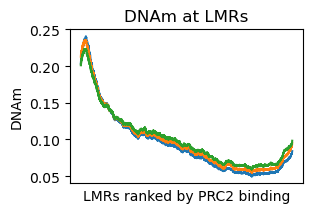

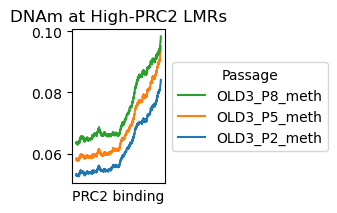

In [25]:

dft= pd.read_csv('data/Old/OLDP2s_methBWs_hESCord_FE.csv',index_col=0) 

cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
#pl=pwg(cells,folder,'passage',figure='t_cell_lmrs_totalMeth')
dg=pprc(df,figure='Fig6b_Olds')

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6b_Olds_zoom2')

In [26]:
%%time


folder='Neo&Old/';cell='ALL_fibropass'

ez=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_ezh2/ENCFF105JFX.bigWig') # EZH2 esc fold 
su=pyBigWig.open('/Users/dsimps93/Project_FibroPass/OurLMRs_Mahdi_ver2/Recreate/data/chip_emb_suz/ENCFF224RZW.bigWig') # suz12 esc fold 

#get the t cell hmr and put in folder that mahdi used...either Ive got it or its somewhere in the shared folder.
# s1. get ezh2 binding within HMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy()
t.columns=['ch','b','e','d']
#t['pr']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)

t['ez']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1)
t['su']=t.apply(lambda x:su.stats(x[0],x[1],x[2])[0],axis=1)
t['pr']=t[['ez','su']].mean(1)

print(len(t))
t=bl(t,'hg38-blacklist.v2.bed.gz') 

#s2. get DNAm within LMRs for each samples 
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth","OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save so you don't need to produce everytime
dft=t.sort_values('pr').reset_index()

dft.to_csv('data/Neo&Old/Neo&Old_methBWs_hESCord_FE.csv') 

77273
NEO2_P2_meth,..........................................................................
NEO2_P5_meth,..........................................................................
NEO2_P8_meth,..........................................................................
OLD3_P2_meth,..........................................................................
OLD3_P5_meth,..........................................................................
OLD3_P8_meth,..........................................................................
CPU times: user 2min 22s, sys: 22 s, total: 2min 44s
Wall time: 2min 48s


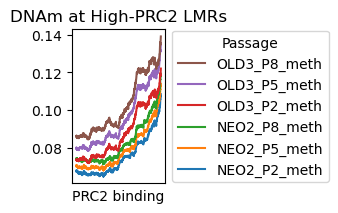

In [27]:

dft= pd.read_csv('data/Neo&Old/Neo&Old_methBWs_hESCord_FE.csv',index_col=0) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth","OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
#dft=t.sort_values('pr').reset_index()
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6c_Olds')

       NEO2_P2_meth  NEO2_P5_meth  NEO2_P8_meth  OLD3_P2_meth  OLD3_P5_meth  \
0             0.172         0.167         0.194         0.473         0.406   
1             0.501         0.446         0.431         0.007         0.059   
2             0.211         0.300         0.200         0.026         0.064   
3             0.268         0.301         0.204         0.069         0.378   
4             0.000         0.257         0.071         0.000         0.000   
...             ...           ...           ...           ...           ...   
74796         0.204         0.194         0.195         0.950         0.863   
74797         0.191         0.216         0.201         0.123         0.124   
74798         0.388         0.418         0.413         0.329         0.352   
74799         0.060         0.053         0.072         0.136         0.135   
74800         0.212         0.237         0.254         0.719         0.957   

       OLD3_P8_meth  
0             0.430  
1      

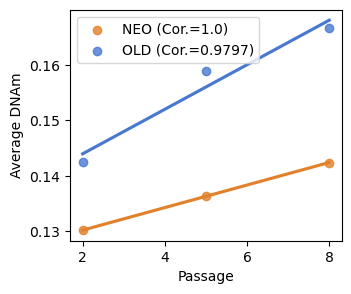

In [28]:
# corr top1000 neo and old

# Read your data
p = pd.read_csv('data/Neo&Old/ALL_fibropass_methBWs_ENC_hESC_EZH2suz12_FE.csv', sep=',', usecols=[9,10, 11, 12, 13, 14])

print(p)

p = p.tail(1000)

# Define the columns to use
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth","OLD3_P2_meth", "OLD3_P5_meth", "OLD3_P8_meth"]

# Calculate the mean for the selected columns
p=pd.DataFrame(p[cells].mean())

p = p.rename(columns={0: 'Average DNAm'})

print(p)

# Create a DataFrame for Passage and Age
p['Passage'] = [2, 5, 8, 2, 5, 8]
p['Age'] = ["NEO", "NEO", "NEO", "OLD", "OLD", "OLD"]

print(p)

# Separate the data into NEO and OLD DataFrames
neo_data = p[p['Age'] == 'NEO']
old_data = p[p['Age'] == 'OLD']

fig, ax = plt.subplots(figsize=(3.5,3))
# Create a linear model for NEO samples
neo_corr = neo_data.corr().values[0, 1].round(4)
sns.regplot(data=neo_data, x='Passage', y='Average DNAm', ci=None, label=f'NEO (Cor.={neo_corr})', color="#E2812C")

# Create a linear model for OLD samples
old_corr = old_data.corr().values[0, 1].round(4)
sns.regplot(data=old_data, x='Passage', y='Average DNAm', ci=None, label=f'OLD (Cor.={old_corr})', color="#4878D0")

# Set titles and labels
#plt.title('Linear Models for NEO and OLD Samples')
plt.xlabel('Passage')
plt.ylabel('Average DNAm')

# Add a legend
plt.legend()

# Save the figure
plt.savefig('figures/Fig6c_NEO&OLD_LMRs_embsort_Top1000Corr.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()